In [67]:
import pandas as pd
import numpy as np
import plotly.express as px
import nltk

from nltk.sentiment import SentimentIntensityAnalyzer

import sys
sys.path.append("..")
from preprocessing_nlp import preprocess, extract_features

PATH = "../../data/"
FILE = "the-office-lines_scripts.csv"

In [68]:
df_raw = pd.read_csv(PATH+FILE, sep=",", index_col="id")
df_raw.head()

,season,episode,scene,line_text,speaker,deleted
id,,,,,,
1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False


In [69]:
param_dict = {
    "concat_scenes": False,
    "extract_direc": False, 
    "remove_punct": True, 
    "rmv_stopwords": True,
    "lwr": True, 
    "exp_contractions": True,
    "conversion": "tokenize",
    "normalize": "stem",
    "tokenizer": ("TreeBankWord", True, PATH+"character_names.csv", PATH+"compound_words_the-office_by_chatgpt.txt")
}

df = preprocess(df_raw, **param_dict)
df.head()

,season,episode,scene,line_text,speaker,season_episode
id,,,,,,
1,1,1,1,"[right, jim, quarterli, look, good, thing, lib...",Michael,101
2,1,1,1,"[oh, told, could, close]",Jim,101
3,1,1,1,"[come, master, guidanc, say, grasshopp]",Michael,101
4,1,1,1,"[actual, call, yeah]",Jim,101
5,1,1,1,"[right, well, let, show, done]",Michael,101


In [70]:
data = df.line_text.values.tolist()

## LDA Attempt 1

In [7]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaModel

dictionary = Dictionary(data)
corpus = [dictionary.doc2bow(doc) for doc in data]

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

lda_model = LdaModel(corpus_tfidf, num_topics=10, id2word=dictionary)

In [8]:
for i, topic in lda_model.show_topics(num_topics=10, num_words=10, formatted=True):
    print('Topic {}: {}'.format(i, topic))

Topic 0: 0.054*"oh" + 0.020*"whoa" + 0.011*"noth" + 0.011*"way" + 0.011*"idea" + 0.011*"work" + 0.010*"fun" + 0.010*"readi" + 0.010*"exactli" + 0.010*"dog"
Topic 1: 0.071*"thank" + 0.018*"jim" + 0.018*"kevin" + 0.017*"cool" + 0.015*"much" + 0.013*"ah" + 0.012*"chuckl" + 0.012*"babi" + 0.010*"watch" + 0.010*"stupid"
Topic 2: 0.161*"yeah" + 0.099*"okay" + 0.033*"great" + 0.024*"darryl" + 0.021*"uh" + 0.020*"huh" + 0.019*"think" + 0.015*"oh" + 0.013*"enough" + 0.011*"need"
Topic 3: 0.028*"andi" + 0.026*"know" + 0.021*"good" + 0.018*"realli" + 0.014*"mean" + 0.010*"mayb" + 0.010*"go" + 0.009*"think" + 0.009*"see" + 0.008*"like"
Topic 4: 0.087*"hey" + 0.044*"god" + 0.028*"oh" + 0.016*"bye" + 0.015*"like" + 0.014*"thought" + 0.014*"mmhmm" + 0.012*"kiss" + 0.011*"guess" + 0.011*"three"
Topic 5: 0.022*"sure" + 0.011*"question" + 0.011*"pleas" + 0.011*"said" + 0.011*"pam" + 0.009*"keep" + 0.009*"better" + 0.008*"play" + 0.008*"care" + 0.008*"take"
Topic 6: 0.080*"ye" + 0.042*"ok" + 0.023*"stop"

## LDA Attempt 2

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a term-document matrix using CountVectorizer
vectorizer = CountVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x)
term_document_matrix = vectorizer.fit_transform(data)

C:\Users\ti-he\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [10]:
from sklearn.decomposition import LatentDirichletAllocation

# Apply LDA to the term-document matrix to extract topics
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(term_document_matrix)

LatentDirichletAllocation(random_state=42)

In [88]:
# Get the top words for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx))
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-10 - 1:-1]]))

Topic 0:
go well think get would know never call back like
Topic 1:
yeah ye dwight um hand great think mean jim look
Topic 2:
love got one two talk time make three like tell
Topic 3:
oh okay sorri god wait whoa hello go pam bye
Topic 4:
ok uh phone andi stop alright said huh car kelli
Topic 5:
realli come say go know tri way laugh ryan good
Topic 6:
know like would nice jim sure think thing realli good
Topic 7:
hey michael us let pam dwight jim look leav door
Topic 8:
right thank good get hi look see oh guy erin
Topic 9:
want go pleas know need anyth get like could take


## SBert

In [71]:
data = [" ".join(l) for l in data]

In [73]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data[:5000], show_progress_bar=True)

Batches: 100%|██████████| 157/157 [00:48<00:00,  3.25it/s]


In [74]:
import umap.umap_ as umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [75]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

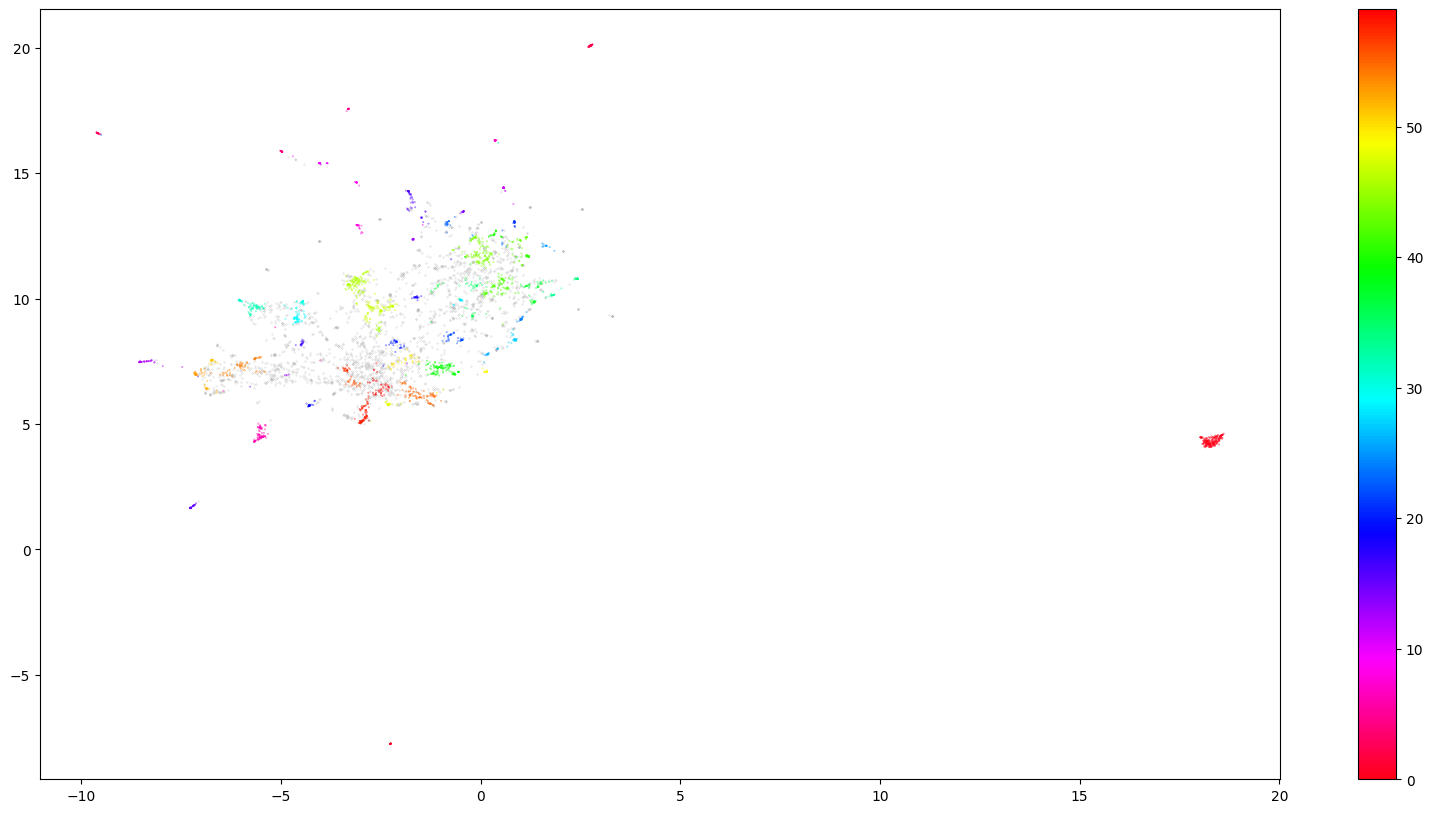

In [76]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [77]:
docs_df = pd.DataFrame(data[:5000], columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [78]:

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [79]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,2414
1,0,217
45,44,132
47,46,126
40,39,121
48,47,105
43,42,95
7,6,93
56,55,89
59,58,79


In [80]:
top_n_words[49]

[('thirti', 0.5169581798814467),
 ('minut', 0.4520184891806925),
 ('year', 0.36895360869448646),
 ('end', 0.3274179438276985),
 ('pushup', 0.28942591497362785),
 ('till', 0.2699006422817984),
 ('rest', 0.2503753695899689),
 ('week', 0.2503753695899689),
 ('lunch', 0.2346115445777035),
 ('like', 0.23149983532255122),
 ('total', 0.22318999223662842),
 ('thought', 0.20575226805617144),
 ('wait', 0.19711197883300313),
 ('said', 0.19506241955744175),
 ('day', 0.19315192388592736),
 ('collect', 0.15447559383272863),
 ('twentyf', 0.14471295748681393),
 ('10', 0.14471295748681393),
 ('wha', 0.14471295748681393),
 ('twenti', 0.1349503211408992)]

In [81]:
top_n_words[45]

[('stop', 0.6637680688112648),
 ('dwight', 0.4669562564990321),
 ('spray', 0.3309638711240571),
 ('pleas', 0.31245102548443626),
 ('shut', 0.25155638548426124),
 ('michael', 0.2005765276171729),
 ('peopl', 0.17661450971919032),
 ('devon', 0.16548193556202856),
 ('good', 0.16102790102527967),
 ('bottl', 0.15714546853789574),
 ('ok', 0.15164986887562565),
 ('away', 0.14040389882089757),
 ('bumper', 0.10346950152946917),
 ('ban', 0.10346950152946917),
 ('concept', 0.10346950152946917),
 ('sadli', 0.10346950152946917),
 ('whine', 0.10346950152946917),
 ('cast', 0.09693037718456403),
 ('grasp', 0.09693037718456403),
 ('jello', 0.09693037718456403)]

In [82]:
top_n_words[48]

[('dollar', 0.35915124636941625),
 ('50', 0.1864209013882397),
 ('20', 0.1462311982931582),
 ('yeah', 0.12528094218015623),
 ('grand', 0.11451959523112162),
 ('reward', 0.11451959523112162),
 ('buck', 0.11185254083294381),
 ('25', 0.11185254083294381),
 ('cent', 0.11185254083294381),
 ('mile', 0.1078309603155588),
 ('bedroom', 0.10356791317684884),
 ('know', 0.09782834957958382),
 ('oscar', 0.08825794689642577),
 ('like', 0.08731202288393698),
 ('million', 0.08186948192481106),
 ('sixmillion', 0.08186948192481106),
 ('oh', 0.0796662884802927),
 ('sheet', 0.07863868425064241),
 ('insist', 0.07863868425064241),
 ('postit', 0.07634639682074774)]

In [83]:
top_n_words[58]

[('eat', 0.18808889553472544),
 ('got', 0.09858404784366737),
 ('like', 0.09754592467597115),
 ('oh', 0.09642103090177859),
 ('chili', 0.09231198715594552),
 ('chees', 0.08999447252805312),
 ('chicken', 0.08168552842340365),
 ('dinner', 0.07807604674885027),
 ('uh', 0.07310437903419682),
 ('nice', 0.07156024929900012),
 ('ye', 0.07086712033661266),
 ('doubl', 0.06593713368281823),
 ('love', 0.06180191814292507),
 ('pam', 0.05867586079815521),
 ('sandwich', 0.056863340065304704),
 ('thank', 0.05416883002555515),
 ('cake', 0.05354217811910042),
 ('grill', 0.05274970694625458),
 ('look', 0.052681701675437946),
 ('smell', 0.05205069783256685)]

In [85]:
# write the function cosine_similarity which uses a matrix as input and returns the cosine similarity matrix
def cosine_similarity(matrix):
    # calculate the dot product between each row
    dot_product = matrix.dot(matrix.T)
    # calculate the norms of each row
    norms = np.array([np.sqrt(np.diagonal(dot_product))])
    # calculate the cosine similarity
    return dot_product / norms / norms.T

In [86]:
for i in range(25):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); print(len(topic_sizes)); topic_sizes.head(10)

36


,Topic,Size
0,-1,2682
1,0,217
25,24,132
26,25,126
27,26,122
21,20,121
31,30,107
23,22,95
3,2,93
6,5,93


In [87]:
top_n_words[0]

[('topic', 1.9162945602007686),
 ('period', 1.9162945602007686),
 ('shirt', 1.8352015385791356),
 ('number', 1.5753449417530834),
 ('head', 1.4071883058798813),
 ('fifti', 0.0),
 ('fifteenth', 0.0),
 ('fiend', 0.0),
 ('fianc', 0.0),
 ('festiv', 0.0),
 ('femal', 0.0),
 ('felt', 0.0),
 ('feloni', 0.0),
 ('fell', 0.0),
 ('feet', 0.0),
 ('feelin', 0.0),
 ('feel', 0.0),
 ('fee', 0.0),
 ('featur', 0.0),
 ('feather', 0.0)]